# **Model Implementation**

Tiny_vit

In [1]:
from datasets import load_dataset
from huggingface_hub import login
import os
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import gc

print("Streaming dataset...")
ds_stream = load_dataset("saberzl/SID_Set", split="train", streaming=True)

# Step 3: Setup directories for 3 classes
save_dir = "/content/sid_images"
os.makedirs(f"{save_dir}/real", exist_ok=True)
os.makedirs(f"{save_dir}/synthetic", exist_ok=True)
os.makedirs(f"{save_dir}/tampered", exist_ok=True)

target_per_class = 3600
class_counts = {'real': 0, 'synthetic': 0, 'tampered': 0}

print(f"Downloading {target_per_class} images per class (Real, Synthetic, Tampered)...")
print("Saving images directly to disk to avoid memory issues\n")

pbar = tqdm(ds_stream)
for sample in pbar:
    # Get label (0=Real, 1=Synthetic, 2=Tampered)
    label = sample.get('label', sample.get('class', None))

    if label is None:
        print(f"Available keys: {sample.keys()}")
        break

    # Map label to class name
    if label == 0:
        class_name = 'real'
    elif label == 1:
        class_name = 'synthetic'
    elif label == 2:
        class_name = 'tampered'
    else:
        continue

    if class_counts[class_name] >= target_per_class:
        if all(count >= target_per_class for count in class_counts.values()):
            print("\n Downloaded target number for all classes!")
            break
        continue

    if 'image' in sample:
        img = sample['image']
        if isinstance(img, Image.Image):
            class_counts[class_name] += 1
            img_filename = f"{class_name}_{class_counts[class_name]:05d}.png"
            img_path = f"{save_dir}/{class_name}/{img_filename}"

            # Convert all images to RGB (handles RGBA, CMYK, L, etc.)
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Save as PNG
            img.save(img_path, 'PNG')
            img.close()

            # Update progress bar
            pbar.set_description(
                f"Real: {class_counts['real']}/{target_per_class} | "
                f"Synth: {class_counts['synthetic']}/{target_per_class} | "
                f"Tamp: {class_counts['tampered']}/{target_per_class}"
            )

            # Force garbage collection every 100 images
            if sum(class_counts.values()) % 100 == 0:
                gc.collect()

pbar.close()

print(f"\n{'='*70}")
print(f"Download Complete!")
print(f"{'='*70}")
print(f"Real images:      {class_counts['real']}")
print(f"Synthetic images: {class_counts['synthetic']}")
print(f"Tampered images:  {class_counts['tampered']}")
print(f"Total images:     {sum(class_counts.values())}")
print(f"Images saved to:  {save_dir}")
print(f"{'='*70}")

# Step 4: Create PyTorch Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

class SIDDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Load real images (label 0)
        real_dir = os.path.join(root_dir, 'real')
        if os.path.exists(real_dir):
            for img_name in sorted(os.listdir(real_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(real_dir, img_name), 0))

        # Load synthetic images (label 1)
        synth_dir = os.path.join(root_dir, 'synthetic')
        if os.path.exists(synth_dir):
            for img_name in sorted(os.listdir(synth_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(synth_dir, img_name), 1))

        # Load tampered images (label 2)
        tamp_dir = os.path.join(root_dir, 'tampered')
        if os.path.exists(tamp_dir):
            for img_name in sorted(os.listdir(tamp_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(tamp_dir, img_name), 2))

        print(f"\nDataset Statistics:")
        print(f"  Real: {sum(1 for _, l in self.samples if l == 0)}")
        print(f"  Synthetic: {sum(1 for _, l in self.samples if l == 1)}")
        print(f"  Tampered: {sum(1 for _, l in self.samples if l == 2)}")
        print(f"  Total: {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label



Streaming dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/249 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/249 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

Saving images directly to disk to avoid memory issues



Real: 1691/3600 | Synth: 1650/3600 | Tamp: 1723/3600: : 5064it [31:30,  2.46it/s]'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: e57023f4-d2a3-4ad5-b205-3db3606c43f3)')' thrown while requesting GET https://huggingface.co/datasets/saberzl/SID_Set/resolve/dc03ead57929879319ce30a82bfcfb8d317b10bd/data/train-00006-of-00249.parquet
Retrying in 1s [Retry 1/5].
Real: 2273/3600 | Synth: 2185/3600 | Tamp: 2294/3600: : 6752it [42:12,  2.55it/s]'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: b8874709-27d9-4086-bf21-688a6b1c9d58)')' thrown while requesting GET https://huggingface.co/datasets/saberzl/SID_Set/resolve/dc03ead57929879319ce30a82bfcfb8d317b10bd/data/train-00008-of-00249.parquet
Retrying in 1s [Retry 1/5].
Real: 2814/3600 | Synth: 2781/3600 | Tamp: 2845/3600: : 8440it [52:41,  2.28it/s]'(ProtocolError('Connection aborted.', RemoteDisconnect


 Downloaded target number for all classes!

Download Complete!
Real images:      3600
Synthetic images: 3600
Tampered images:  3600
Total images:     10800
Images saved to:  /content/sid_images


In [2]:
!pip install torch torchvision tqdm pillow -q

In [3]:
!pip install timm -q

# Importing librarires

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

#Configuration

In [5]:


class Config:
    # Paths
    data_dir = '/content/sid_images'
    save_dir = './checkpoints'

    # Model
    backbone = 'tiny_vit'
    pretrained = True
    num_classes = 3

    # Training
    epochs = 20
    batch_size = 32
    lr = 1e-4
    weight_decay = 1e-4
    num_workers = 2


    save_freq = 5
    seed = 42

config = Config()

#random seed for reproducibility
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# Create save directory
os.makedirs(config.save_dir, exist_ok=True)

print("Configuration loaded!")
print(f"Data directory: {config.data_dir}")
print(f"Save directory: {config.save_dir}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")



Configuration loaded!
Data directory: /content/sid_images
Save directory: ./checkpoints
Device: GPU


#Dataset Class

In [6]:
class SIDDataset(Dataset):

    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.samples = []

        # Load real images
        real_dir = os.path.join(root_dir, 'real')
        if os.path.exists(real_dir):
            for img_name in sorted(os.listdir(real_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(real_dir, img_name), 0))

        # Load synthetic images
        synth_dir = os.path.join(root_dir, 'synthetic')
        if os.path.exists(synth_dir):
            for img_name in sorted(os.listdir(synth_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(synth_dir, img_name), 1))

        # Load tampered images
        tamp_dir = os.path.join(root_dir, 'tampered')
        if os.path.exists(tamp_dir):
            for img_name in sorted(os.listdir(tamp_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(tamp_dir, img_name), 2))

        # Split into train/val
        np.random.seed(42)
        indices = np.random.permutation(len(self.samples))
        split_idx = int(0.8 * len(self.samples))

        if split == 'train':
            indices = indices[:split_idx]
        else:
            indices = indices[split_idx:]

        self.samples = [self.samples[i] for i in indices]

        print(f"\n{split.capitalize()} Dataset Statistics:")
        print(f"  Real: {sum(1 for _, l in self.samples if l == 0)}")
        print(f"  Synthetic: {sum(1 for _, l in self.samples if l == 1)}")
        print(f"  Tampered: {sum(1 for _, l in self.samples if l == 2)}")
        print(f"  Total: {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

print("Dataset class defined!")

Dataset class defined!


#Model Definition

In [7]:
from timm import create_model

class Timm(nn.Module):
    def __init__(self, num_classes=3, backbone='tiny_vit', pretrained=True):
        super(Timm, self).__init__()

        if backbone == 'tiny_vit':
            self.backbone = create_model(
                'tiny_vit_5m_224',
                pretrained=pretrained,
                num_classes=num_classes
            )
        else:
            raise ValueError("Backbone not supported")

    def forward(self, x):
        return self.backbone(x)


In [8]:
def train_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Train]")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

print("Training function defined!")

Training function defined!


In [9]:
def validate(model, dataloader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    num_classes = 3
    confusion_matrix = torch.zeros(num_classes, num_classes)

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Val]")
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for t, p in zip(labels.cpu(), predicted.cpu()):
                confusion_matrix[t.long(), p.long()] += 1

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    class_names = ['Real', 'Synthetic', 'Tampered']
    per_class_metrics = {}

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp

        total_class = confusion_matrix[i, :].sum()
        class_acc = float(tp / total_class) if total_class > 0 else 0.0
        precision = float(tp / (tp + fp)) if (tp + fp) > 0 else 0.0
        recall = float(tp / (tp + fn)) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        per_class_metrics[class_names[i]] = {
            'accuracy': class_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    print(f"\n{'='*60}")
    print(f"Validation Results (Epoch {epoch+1}):")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"Average Loss: {avg_loss:.4f}")
    print("\nPer-Class Metrics:")
    for class_name, metrics in per_class_metrics.items():
        print(f"\n{class_name}:")
        print(f"  Accuracy:  {metrics['accuracy']*100:.2f}%")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1:        {metrics['f1']:.4f}")

    print("\nConfusion Matrix:")
    print(f"{'':12}", end="")
    for name in class_names:
        print(f"{name:>12}", end="")
    print()
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<12}", end="")
        for j in range(num_classes):
            print(f"{int(confusion_matrix[i, j]):>12}", end="")
        print()
    print(f"{'='*60}\n")

    return avg_loss, accuracy, per_class_metrics, confusion_matrix

print("Validation function defined!")



Validation function defined!


In [10]:
def plot_training_history(results, save_path):
    """Plot training history"""
    epochs = [r['epoch'] for r in results]
    train_losses = [r['train_loss'] for r in results]
    val_losses = [r['val_loss'] for r in results]
    train_accs = [r['train_acc'] for r in results]
    val_accs = [r['val_acc'] for r in results]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_losses, label='Train Loss', marker='o')
    ax1.plot(epochs, val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(epochs, train_accs, label='Train Acc', marker='o')
    ax2.plot(epochs, val_accs, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Training history saved to {save_path}")

def plot_confusion_matrix(cm, save_path):
    """Plot confusion matrix"""
    class_names = ['Real', 'Synthetic', 'Tampered']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm.numpy(), annot=True, fmt='.0f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Final Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Confusion matrix saved to {save_path}")

print("Visualization functions defined!")



Visualization functions defined!


#Creating Datasets and Dataloaders

In [11]:
class SIDDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.samples = []

        # Load images by class
        class_dirs = {'real': 0, 'synthetic': 1, 'tampered': 2}
        for cls_name, cls_label in class_dirs.items():
            cls_dir = os.path.join(root_dir, cls_name)
            if os.path.exists(cls_dir):
                for img_name in sorted(os.listdir(cls_dir)):
                    if img_name.endswith('.png'):
                        self.samples.append((os.path.join(cls_dir, img_name), cls_label))

        # Shuffle indices
        np.random.seed(42)
        indices = np.random.permutation(len(self.samples))

        # Split 70% train, 15% val, 15% test
        n = len(self.samples)
        train_idx = int(0.7 * n)
        val_idx = int(0.85 * n)

        if split == 'train':
            indices = indices[:train_idx]
        elif split == 'val':
            indices = indices[train_idx:val_idx]
        else:  # test
            indices = indices[val_idx:]

        self.samples = [self.samples[i] for i in indices]

        print(f"\n{split.capitalize()} Dataset Statistics:")
        print(f"  Real: {sum(1 for _, l in self.samples if l == 0)}")
        print(f"  Synthetic: {sum(1 for _, l in self.samples if l == 1)}")
        print(f"  Tampered: {sum(1 for _, l in self.samples if l == 2)}")
        print(f"  Total: {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [12]:
# Transforms
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Datasets
train_dataset = SIDDataset(config.data_dir, transform=train_transform, split='train')
val_dataset = SIDDataset(config.data_dir, transform=val_test_transform, split='val')
test_dataset = SIDDataset(config.data_dir, transform=val_test_transform, split='test')

# Dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")



Train Dataset Statistics:
  Real: 2537
  Synthetic: 2533
  Tampered: 2489
  Total: 7559 images

Val Dataset Statistics:
  Real: 522
  Synthetic: 523
  Tampered: 576
  Total: 1621 images

Test Dataset Statistics:
  Real: 541
  Synthetic: 544
  Tampered: 535
  Total: 1620 images
Train batches: 237, Val batches: 51, Test batches: 51


#Initialize Model, Loss, Optimizer

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Create model
print("Creating model...")
model = Timm(num_classes=config.num_classes,
                   backbone=config.backbone,
                   pretrained=config.pretrained)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=config.epochs)

print("\nModel, loss, and optimizer initialized!")


Using device: cuda
Creating model...


model.safetensors:   0%|          | 0.00/48.4M [00:00<?, ?B/s]

Total parameters: 5,072,727
Trainable parameters: 5,072,727

Model, loss, and optimizer initialized!


# **Model Training**

In [14]:
print(f"\n{'='*70}")
print(f"Starting Training")
print(f"{'='*70}")
print(f"Total epochs: {config.epochs}")
print(f"Batch size: {config.batch_size}")
print(f"Learning rate: {config.lr}")
print(f"{'='*70}\n")

best_acc = 0.0
results = []

for epoch in range(config.epochs):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )

    # Validate
    val_loss, val_acc, per_class_metrics, cm = validate(
        model, val_loader, criterion, device, epoch
    )

    scheduler.step()

    # Save results
    results.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'per_class_metrics': per_class_metrics
    })

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, os.path.join(config.save_dir, 'best_model.pth'))
        print(f"✓ New best model saved! Accuracy: {val_acc:.2f}%\n")

    # Save periodic checkpoint
    if (epoch + 1) % config.save_freq == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, os.path.join(config.save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

# Save final model
torch.save({
    'epoch': config.epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'results': results,
}, os.path.join(config.save_dir, 'final_model.pth'))

# Save results as JSON
with open(os.path.join(config.save_dir, 'training_results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n{'='*70}")
print(f"Training Completed!")
print(f"Best Validation Accuracy: {best_acc:.2f}%")
print(f"Models saved to: {config.save_dir}")
print(f"{'='*70}\n")



Starting Training
Total epochs: 20
Batch size: 32
Learning rate: 0.0001



Epoch 1 [Val]: 100%|██████████| 51/51 [00:55<00:00,  1.10s/it, loss=0.4074, acc=85.26%]



Validation Results (Epoch 1):
Overall Accuracy: 85.26%
Average Loss: 0.3375

Per-Class Metrics:

Real:
  Accuracy:  66.67%
  Precision: 0.8529
  Recall:    0.6667
  F1:        0.7484

Synthetic:
  Accuracy:  99.81%
  Precision: 0.9739
  Recall:    0.9981
  F1:        0.9858

Tampered:
  Accuracy:  88.89%
  Precision: 0.7563
  Recall:    0.8889
  F1:        0.8172

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 348          10         164
Synthetic              0         522           1
Tampered              60           4         512

✓ New best model saved! Accuracy: 85.26%



Epoch 2 [Val]: 100%|██████████| 51/51 [00:54<00:00,  1.07s/it, loss=0.1769, acc=90.38%]



Validation Results (Epoch 2):
Overall Accuracy: 90.38%
Average Loss: 0.2382

Per-Class Metrics:

Real:
  Accuracy:  86.97%
  Precision: 0.8392
  Recall:    0.8697
  F1:        0.8542

Synthetic:
  Accuracy:  100.00%
  Precision: 0.9924
  Recall:    1.0000
  F1:        0.9962

Tampered:
  Accuracy:  84.72%
  Precision: 0.8825
  Recall:    0.8472
  F1:        0.8645

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 454           3          65
Synthetic              0         523           0
Tampered              87           1         488

✓ New best model saved! Accuracy: 90.38%



Epoch 3 [Val]: 100%|██████████| 51/51 [00:54<00:00,  1.07s/it, loss=0.2201, acc=90.07%]



Validation Results (Epoch 3):
Overall Accuracy: 90.07%
Average Loss: 0.2265

Per-Class Metrics:

Real:
  Accuracy:  82.95%
  Precision: 0.8591
  Recall:    0.8295
  F1:        0.8441

Synthetic:
  Accuracy:  100.00%
  Precision: 0.9943
  Recall:    1.0000
  F1:        0.9971

Tampered:
  Accuracy:  87.50%
  Precision: 0.8528
  Recall:    0.8750
  F1:        0.8638

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 433           2          87
Synthetic              0         523           0
Tampered              71           1         504



Epoch 4 [Val]: 100%|██████████| 51/51 [00:55<00:00,  1.09s/it, loss=0.2224, acc=90.38%]



Validation Results (Epoch 4):
Overall Accuracy: 90.38%
Average Loss: 0.2373

Per-Class Metrics:

Real:
  Accuracy:  89.08%
  Precision: 0.8289
  Recall:    0.8908
  F1:        0.8587

Synthetic:
  Accuracy:  99.81%
  Precision: 0.9849
  Recall:    0.9981
  F1:        0.9915

Tampered:
  Accuracy:  82.99%
  Precision: 0.9019
  Recall:    0.8299
  F1:        0.8644

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 465           5          52
Synthetic              1         522           0
Tampered              95           3         478



Epoch 5 [Val]: 100%|██████████| 51/51 [00:55<00:00,  1.08s/it, loss=0.2152, acc=90.38%]



Validation Results (Epoch 5):
Overall Accuracy: 90.38%
Average Loss: 0.2332

Per-Class Metrics:

Real:
  Accuracy:  88.51%
  Precision: 0.8309
  Recall:    0.8851
  F1:        0.8571

Synthetic:
  Accuracy:  100.00%
  Precision: 0.9868
  Recall:    1.0000
  F1:        0.9934

Tampered:
  Accuracy:  83.33%
  Precision: 0.8972
  Recall:    0.8333
  F1:        0.8641

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 462           5          55
Synthetic              0         523           0
Tampered              94           2         480



Epoch 6 [Val]: 100%|██████████| 51/51 [00:54<00:00,  1.08s/it, loss=0.1574, acc=90.68%]



Validation Results (Epoch 6):
Overall Accuracy: 90.68%
Average Loss: 0.2485

Per-Class Metrics:

Real:
  Accuracy:  90.04%
  Precision: 0.8275
  Recall:    0.9004
  F1:        0.8624

Synthetic:
  Accuracy:  99.81%
  Precision: 0.9943
  Recall:    0.9981
  F1:        0.9962

Tampered:
  Accuracy:  82.99%
  Precision: 0.9053
  Recall:    0.8299
  F1:        0.8659

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 470           3          49
Synthetic              0         522           1
Tampered              98           0         478

✓ New best model saved! Accuracy: 90.68%



Epoch 7 [Val]: 100%|██████████| 51/51 [00:54<00:00,  1.07s/it, loss=0.2919, acc=89.39%]



Validation Results (Epoch 7):
Overall Accuracy: 89.39%
Average Loss: 0.3049

Per-Class Metrics:

Real:
  Accuracy:  92.15%
  Precision: 0.7911
  Recall:    0.9215
  F1:        0.8513

Synthetic:
  Accuracy:  99.81%
  Precision: 0.9812
  Recall:    0.9981
  F1:        0.9896

Tampered:
  Accuracy:  77.43%
  Precision: 0.9272
  Recall:    0.7743
  F1:        0.8439

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 481           6          35
Synthetic              1         522           0
Tampered             126           4         446



Epoch 8 [Val]: 100%|██████████| 51/51 [00:54<00:00,  1.07s/it, loss=0.0885, acc=88.40%]



Validation Results (Epoch 8):
Overall Accuracy: 88.40%
Average Loss: 0.3608

Per-Class Metrics:

Real:
  Accuracy:  93.68%
  Precision: 0.7605
  Recall:    0.9368
  F1:        0.8395

Synthetic:
  Accuracy:  99.81%
  Precision: 0.9943
  Recall:    0.9981
  F1:        0.9962

Tampered:
  Accuracy:  73.26%
  Precision: 0.9316
  Recall:    0.7326
  F1:        0.8202

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 489           2          31
Synthetic              1         522           0
Tampered             153           1         422



Epoch 9 [Val]: 100%|██████████| 51/51 [00:54<00:00,  1.07s/it, loss=0.1706, acc=90.38%]



Validation Results (Epoch 9):
Overall Accuracy: 90.38%
Average Loss: 0.2937

Per-Class Metrics:

Real:
  Accuracy:  89.08%
  Precision: 0.8245
  Recall:    0.8908
  F1:        0.8564

Synthetic:
  Accuracy:  99.62%
  Precision: 0.9981
  Recall:    0.9962
  F1:        0.9971

Tampered:
  Accuracy:  83.16%
  Precision: 0.8953
  Recall:    0.8316
  F1:        0.8623

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 465           1          56
Synthetic              2         521           0
Tampered              97           0         479



Epoch 10 [Val]: 100%|██████████| 51/51 [00:54<00:00,  1.07s/it, loss=0.3048, acc=89.57%]



Validation Results (Epoch 10):
Overall Accuracy: 89.57%
Average Loss: 0.3001

Per-Class Metrics:

Real:
  Accuracy:  89.08%
  Precision: 0.8144
  Recall:    0.8908
  F1:        0.8509

Synthetic:
  Accuracy:  99.81%
  Precision: 0.9775
  Recall:    0.9981
  F1:        0.9877

Tampered:
  Accuracy:  80.73%
  Precision: 0.9012
  Recall:    0.8073
  F1:        0.8516

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 465           6          51
Synthetic              1         522           0
Tampered             105           6         465



Epoch 11 [Val]: 100%|██████████| 51/51 [00:55<00:00,  1.09s/it, loss=0.4238, acc=90.25%]



Validation Results (Epoch 11):
Overall Accuracy: 90.25%
Average Loss: 0.3191

Per-Class Metrics:

Real:
  Accuracy:  87.55%
  Precision: 0.8355
  Recall:    0.8755
  F1:        0.8550

Synthetic:
  Accuracy:  100.00%
  Precision: 0.9831
  Recall:    1.0000
  F1:        0.9915

Tampered:
  Accuracy:  83.85%
  Precision: 0.8911
  Recall:    0.8385
  F1:        0.8640

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 457           6          59
Synthetic              0         523           0
Tampered              90           3         483



Epoch 12 [Val]: 100%|██████████| 51/51 [00:55<00:00,  1.09s/it, loss=0.3617, acc=90.13%]



Validation Results (Epoch 12):
Overall Accuracy: 90.13%
Average Loss: 0.3184

Per-Class Metrics:

Real:
  Accuracy:  88.12%
  Precision: 0.8288
  Recall:    0.8812
  F1:        0.8542

Synthetic:
  Accuracy:  100.00%
  Precision: 0.9887
  Recall:    1.0000
  F1:        0.9943

Tampered:
  Accuracy:  82.99%
  Precision: 0.8901
  Recall:    0.8299
  F1:        0.8589

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 460           3          59
Synthetic              0         523           0
Tampered              95           3         478



Epoch 13 [Val]: 100%|██████████| 51/51 [00:55<00:00,  1.09s/it, loss=0.5436, acc=89.70%]



Validation Results (Epoch 13):
Overall Accuracy: 89.70%
Average Loss: 0.3530

Per-Class Metrics:

Real:
  Accuracy:  86.78%
  Precision: 0.8266
  Recall:    0.8678
  F1:        0.8467

Synthetic:
  Accuracy:  100.00%
  Precision: 0.9794
  Recall:    1.0000
  F1:        0.9896

Tampered:
  Accuracy:  82.99%
  Precision: 0.8868
  Recall:    0.8299
  F1:        0.8574

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 453           8          61
Synthetic              0         523           0
Tampered              95           3         478



Epoch 14 [Val]: 100%|██████████| 51/51 [00:54<00:00,  1.08s/it, loss=0.4189, acc=90.50%]



Validation Results (Epoch 14):
Overall Accuracy: 90.50%
Average Loss: 0.3281

Per-Class Metrics:

Real:
  Accuracy:  88.51%
  Precision: 0.8354
  Recall:    0.8851
  F1:        0.8595

Synthetic:
  Accuracy:  99.62%
  Precision: 0.9924
  Recall:    0.9962
  F1:        0.9943

Tampered:
  Accuracy:  84.03%
  Precision: 0.8913
  Recall:    0.8403
  F1:        0.8651

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 462           2          58
Synthetic              1         521           1
Tampered              90           2         484



Epoch 15 [Val]: 100%|██████████| 51/51 [00:55<00:00,  1.08s/it, loss=0.5018, acc=90.01%]



Validation Results (Epoch 15):
Overall Accuracy: 90.01%
Average Loss: 0.3546

Per-Class Metrics:

Real:
  Accuracy:  90.42%
  Precision: 0.8110
  Recall:    0.9042
  F1:        0.8551

Synthetic:
  Accuracy:  99.81%
  Precision: 0.9886
  Recall:    0.9981
  F1:        0.9933

Tampered:
  Accuracy:  80.73%
  Precision: 0.9100
  Recall:    0.8073
  F1:        0.8556

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 472           4          46
Synthetic              1         522           0
Tampered             109           2         465



Epoch 16 [Val]: 100%|██████████| 51/51 [00:54<00:00,  1.07s/it, loss=0.5320, acc=90.07%]



Validation Results (Epoch 16):
Overall Accuracy: 90.07%
Average Loss: 0.3744

Per-Class Metrics:

Real:
  Accuracy:  90.80%
  Precision: 0.8116
  Recall:    0.9080
  F1:        0.8571

Synthetic:
  Accuracy:  99.81%
  Precision: 0.9868
  Recall:    0.9981
  F1:        0.9924

Tampered:
  Accuracy:  80.56%
  Precision: 0.9134
  Recall:    0.8056
  F1:        0.8561

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 474           4          44
Synthetic              1         522           0
Tampered             109           3         464



Epoch 17 [Val]: 100%|██████████| 51/51 [00:54<00:00,  1.07s/it, loss=0.5588, acc=90.25%]



Validation Results (Epoch 17):
Overall Accuracy: 90.25%
Average Loss: 0.3451

Per-Class Metrics:

Real:
  Accuracy:  86.21%
  Precision: 0.8443
  Recall:    0.8621
  F1:        0.8531

Synthetic:
  Accuracy:  100.00%
  Precision: 0.9868
  Recall:    1.0000
  F1:        0.9934

Tampered:
  Accuracy:  85.07%
  Precision: 0.8781
  Recall:    0.8507
  F1:        0.8642

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 450           4          68
Synthetic              0         523           0
Tampered              83           3         490



Epoch 18 [Val]: 100%|██████████| 51/51 [00:54<00:00,  1.08s/it, loss=0.6798, acc=89.82%]



Validation Results (Epoch 18):
Overall Accuracy: 89.82%
Average Loss: 0.3797

Per-Class Metrics:

Real:
  Accuracy:  89.27%
  Precision: 0.8175
  Recall:    0.8927
  F1:        0.8535

Synthetic:
  Accuracy:  100.00%
  Precision: 0.9757
  Recall:    1.0000
  F1:        0.9877

Tampered:
  Accuracy:  81.08%
  Precision: 0.9068
  Recall:    0.8108
  F1:        0.8561

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 466           8          48
Synthetic              0         523           0
Tampered             104           5         467



Epoch 19 [Val]: 100%|██████████| 51/51 [00:55<00:00,  1.08s/it, loss=0.5749, acc=90.50%]



Validation Results (Epoch 19):
Overall Accuracy: 90.50%
Average Loss: 0.3635

Per-Class Metrics:

Real:
  Accuracy:  88.12%
  Precision: 0.8364
  Recall:    0.8812
  F1:        0.8582

Synthetic:
  Accuracy:  100.00%
  Precision: 0.9887
  Recall:    1.0000
  F1:        0.9943

Tampered:
  Accuracy:  84.03%
  Precision: 0.8930
  Recall:    0.8403
  F1:        0.8658

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 460           4          58
Synthetic              0         523           0
Tampered              90           2         484



Epoch 20 [Val]: 100%|██████████| 51/51 [00:55<00:00,  1.09s/it, loss=0.5807, acc=90.38%]



Validation Results (Epoch 20):
Overall Accuracy: 90.38%
Average Loss: 0.3665

Per-Class Metrics:

Real:
  Accuracy:  89.66%
  Precision: 0.8254
  Recall:    0.8966
  F1:        0.8595

Synthetic:
  Accuracy:  100.00%
  Precision: 0.9849
  Recall:    1.0000
  F1:        0.9924

Tampered:
  Accuracy:  82.29%
  Precision: 0.9063
  Recall:    0.8229
  F1:        0.8626

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 468           5          49
Synthetic              0         523           0
Tampered              99           3         474


Training Completed!
Best Validation Accuracy: 90.68%
Models saved to: ./checkpoints



#Plot

Generating plots...


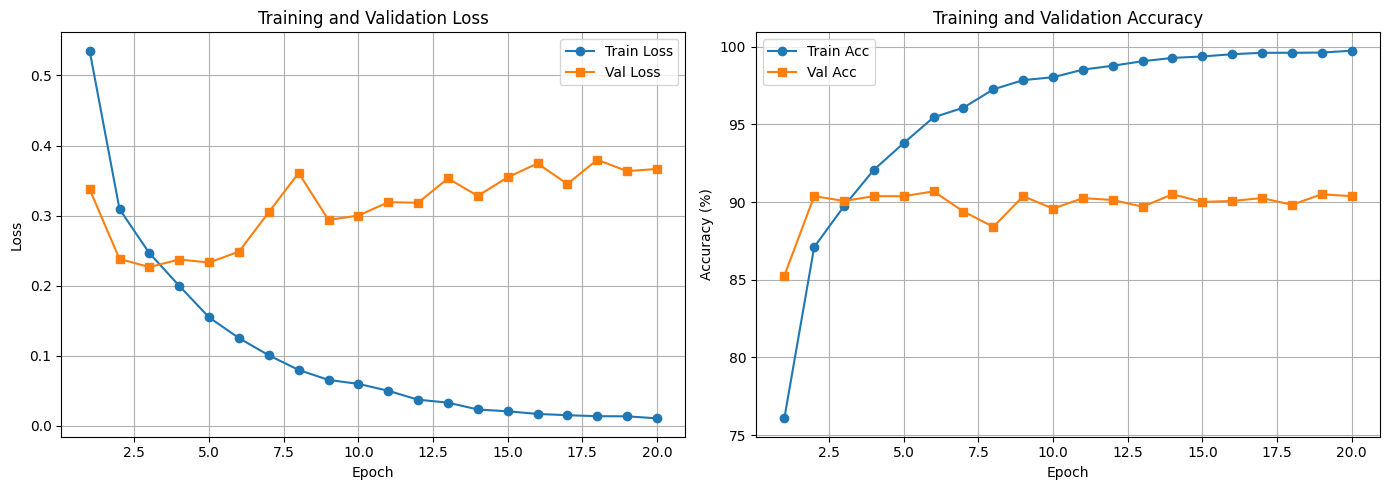

Training history saved to ./checkpoints/training_history.png


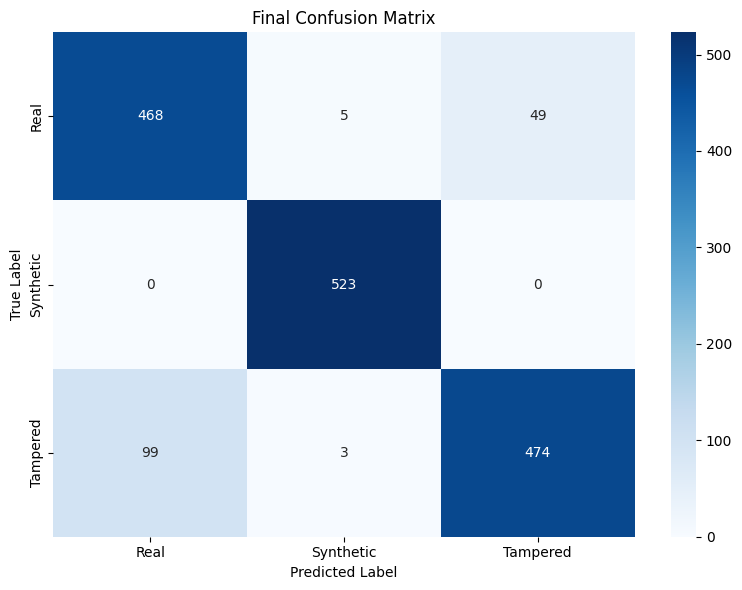

Confusion matrix saved to ./checkpoints/confusion_matrix.png


In [15]:
print("Generating plots...")

# Plot training history
plot_training_history(results, os.path.join(config.save_dir, 'training_history.png'))

# Plot final confusion matrix
plot_confusion_matrix(cm, os.path.join(config.save_dir, 'confusion_matrix.png'))

In [16]:
def evaluate_model_full(model, dataloader, device, class_names=['Real','Synthetic','Tampered'], set_name='Test'):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"{set_name} Evaluation"):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    # Convert to arrays
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.vstack(all_probs)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Overall accuracy
    acc = (all_labels == all_preds).mean() * 100

    # Per-class metrics
    per_class_precision = precision_score(all_labels, all_preds, labels=[0,1,2], average=None)
    per_class_recall = recall_score(all_labels, all_preds, labels=[0,1,2], average=None)
    per_class_f1 = f1_score(all_labels, all_preds, labels=[0,1,2], average=None)

    # Macro metrics
    macro_precision = precision_score(all_labels, all_preds, average='macro')
    macro_recall = recall_score(all_labels, all_preds, average='macro')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    # Weighted metrics
    weighted_precision = precision_score(all_labels, all_preds, average='weighted')
    weighted_recall = recall_score(all_labels, all_preds, average='weighted')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

    # AUC
    labels_onehot = np.zeros((all_labels.size, len(class_names)))
    labels_onehot[np.arange(all_labels.size), all_labels] = 1
    auc = roc_auc_score(labels_onehot, all_probs, average='macro')

    # Print metrics
    print(f"\n{'='*60}")
    print(f"{set_name} Metrics")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {acc:.2f}%")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall:    {macro_recall:.4f}")
    print(f"Macro F1:        {macro_f1:.4f}")
    print(f"Weighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall:    {weighted_recall:.4f}")
    print(f"Weighted F1:        {weighted_f1:.4f}")
    print(f"AUC: {auc:.4f}")

    print("\nPer-Class Metrics:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'{set_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': acc,
        'macro': {'precision': macro_precision, 'recall': macro_recall, 'f1': macro_f1},
        'weighted': {'precision': weighted_precision, 'recall': weighted_recall, 'f1': weighted_f1},
        'per_class': {cls: {'precision': per_class_precision[i], 'recall': per_class_recall[i], 'f1': per_class_f1[i]}
                      for i, cls in enumerate(class_names)},
        'auc': auc,
        'confusion_matrix': cm
    }

Test Evaluation: 100%|██████████| 51/51 [00:56<00:00,  1.10s/it]



Test Metrics
Overall Accuracy: 90.31%
Macro Precision: 0.9036
Macro Recall:    0.9026
Macro F1:        0.9024
Weighted Precision: 0.9039
Weighted Recall:    0.9031
Weighted F1:        0.9028
AUC: 0.9764

Per-Class Metrics:
Real: Precision=0.8351, Recall=0.8891, F1=0.8612
Synthetic: Precision=0.9945, Recall=1.0000, F1=0.9973
Tampered: Precision=0.8813, Recall=0.8187, F1=0.8488


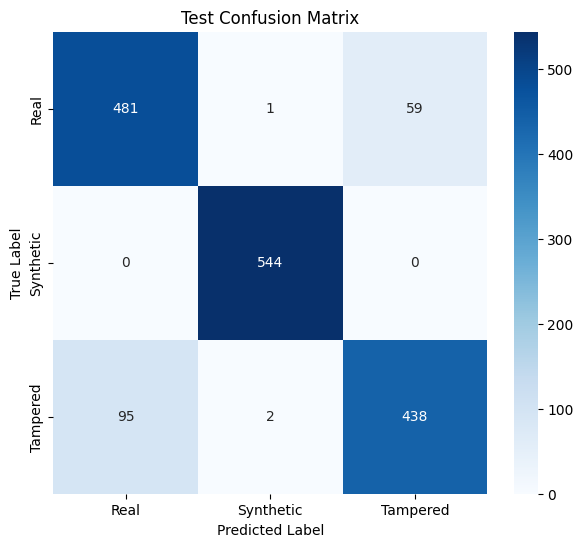

In [17]:
checkpoint = torch.load('./checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

results = evaluate_model_full(model, test_loader, device, set_name='Test')
